In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd


In [20]:
import wandb

### 数据导入

In [21]:
df1=pd.read_excel(r"C:\Users\27968\Desktop\学习\计算机\机器学习与数据挖掘\2024期末大作业\2024期末大作业\缺陷检测.xlsx")

In [23]:
df=df1

In [24]:
df.head(3)

,时间X1,缺陷累计产生数量X2,特征X3,特征X4,特征X5,特征X6,特征X7,特征X8,特征X9,缺陷检测质量风险 Y
0,2050-12-31 06:43:39,0,40,43,0,0,0,0,0,无质量隐患
1,2050-12-31 06:44:09,0,120,146,0,0,0,0,0,NaN
2,2050-12-31 06:44:39,0,120,146,0,0,0,0,0,NaN


In [25]:
df['缺陷检测质量风险 Y'].value_counts()

缺陷检测质量风险 Y
无质量隐患    97
有质量隐患    44
Name: count, dtype: int64

### 数据预处理

In [26]:
def generate_shift_ids(series):
    # 创建一个新的ID列，初始值为0
    ids = pd.Series(0, index=series.index)
    current_id = 1
    last_valid_idx = None
    
    # 遍历series中的每个值和它的索引
    for idx in series.index:
        if pd.notna(series[idx]):  # 如果是非缺失值
            if last_valid_idx is not None:  # 如果不是第一个非缺失值
                # 将两个非缺失值之间的所有行赋予相同的ID
                ids.loc[last_valid_idx:idx] = current_id
                current_id += 1
            last_valid_idx = idx
    
    # 处理最后一段
    if last_valid_idx is not None:
        ids.loc[last_valid_idx:] = current_id
        
    return ids

# 使用示例：
df['shift_id'] = generate_shift_ids(df['缺陷检测质量风险 Y'])

In [27]:
df['shift_id'].max() # 有多少个不同的ID

141

In [28]:
def f(group):
    x1 = group.iloc[[0]]
    x2 = group[group['缺陷累计产生数量X2'] != group['缺陷累计产生数量X2'].shift()]
    x1 = pd.concat([x1, x2])
    return x1

# 按班次分组并处理
df_new = df.groupby('shift_id').apply(f)
#去除重复值
df_new = df_new.drop_duplicates()

C:\Users\27968\AppData\Local\Temp\ipykernel_73304\70679916.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [29]:
df_new.head(3)

时间X1  缺陷累计产生数量X2   特征X3   特征X4  特征X5  特征X6  特征X7  \
shift_id                                                                       
1        0   2050-12-31 06:43:39           0     40     43     0     0     0   
         119 2050-12-31 07:43:11           3  13150  13267     0     0     4   
         226 2050-12-31 08:36:42           6  31190  31283     3     0     5   

              特征X8  特征X9 缺陷检测质量风险 Y  shift_id  
shift_id                                       
1        0       0     0      无质量隐患         1  
         119     2    21        NaN         1  
         226     2    24        NaN         1

In [30]:
#删除现有的索引
df_new.reset_index(drop=True, inplace=True)
shift_counts = df_new.groupby('shift_id').size()

In [31]:
df_new

,时间X1,缺陷累计产生数量X2,特征X3,特征X4,特征X5,特征X6,特征X7,特征X8,特征X9,缺陷检测质量风险 Y,shift_id
0,2050-12-31 06:43:39,0,40,43,0,0,0,0,0,无质量隐患,1
1,2050-12-31 07:43:11,3,13150,13267,0,0,4,2,21,NaN,1
2,2050-12-31 08:36:42,6,31190,31283,3,0,5,2,24,NaN,1
3,2050-12-31 09:31:44,9,49260,49313,3,0,13,5,47,NaN,1
4,2050-12-31 10:31:46,12,67570,67493,3,0,13,5,61,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
1179,2051-03-30 22:52:56,27,117320,117376,4,0,48,1,169,NaN,141
1180,2051-03-30 23:04:26,30,121250,121147,6,0,58,4,178,NaN,141
1181,2051-03-31 00:01:28,33,139410,139254,6,0,66,4,197,NaN,141
1182,2051-03-31 00:44:29,36,153650,153522,7,0,87,6,214,NaN,141


In [32]:
print(shift_counts)
print(f'最大的班次为：{shift_counts.max()}')  # 最大的班次有多少行


shift_id
1      10
2       6
3       4
4       6
5       2
       ..
137     2
138    11
139    15
140    14
141    14
Length: 141, dtype: int64
最大的班次为：23


In [33]:
fig = px.histogram(shift_counts, title='频数分布直方图')
fig.show()

## 朴素思考：视为单个时间序列

### 数据准备

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [35]:
df_new['时间X1'] = pd.to_datetime(df_new['时间X1'])
#把缺陷检测质量风险 Y按照每一个id进行分组，每一个组的值和第一个值一样
df_new['缺陷检测质量风险 Y'] = df_new.groupby('shift_id')['缺陷检测质量风险 Y'].transform(lambda x: x.fillna(x.iloc[0]))
df_new['缺陷检测质量风险 Y'] = df_new['缺陷检测质量风险 Y'].map({'有质量隐患': 1, '无质量隐患': 0})


In [36]:
df_new.head(3)

,时间X1,缺陷累计产生数量X2,特征X3,特征X4,特征X5,特征X6,特征X7,特征X8,特征X9,缺陷检测质量风险 Y,shift_id
0,2050-12-31 06:43:39,0,40,43,0,0,0,0,0,0,1
1,2050-12-31 07:43:11,3,13150,13267,0,0,4,2,21,0,1
2,2050-12-31 08:36:42,6,31190,31283,3,0,5,2,24,0,1


In [37]:
df_new['时间X1'] = pd.to_datetime(df_new['时间X1']).astype(np.int64) // 10**9  # 转换为Unix时间戳
X = df_new.drop(columns=['缺陷检测质量风险 Y','shift_id']).values 
Y = df_new['缺陷检测质量风险 Y'].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X)
Y_tensor = torch.FloatTensor(Y)



### 模型定义

#### DNN

In [38]:
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.model = nn.Sequential(
            # 第一层：输入层到第一个隐藏层
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            # 第二层：第一个隐藏层到第二个隐藏层
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            # 第三层：第二个隐藏层到第三个隐藏层
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            # 输出层
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

#### RNN

In [39]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, 64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(2)  # 添加feature维度
        output, _ = self.rnn(x)
        output = output[:, -1, :]  # 取最后一个时间步
        x = self.dropout(output)
        x = self.sigmoid(self.fc(x))
        return x

#### LSTM

In [40]:
class LSTM(nn.Module):
    def __init__(self, input_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(2)  # 添加feature维度
        output, _ = self.lstm(x)
        output = output[:, -1, :]  # 取最后一个时间步
        x = self.dropout(output)
        x = self.sigmoid(self.fc(x))
        return x

#### 训练与评估函数

In [41]:

# 训练函数
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()


# 评估函数        
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(batch_y.numpy())
    return np.array(all_preds), np.array(all_labels)

#### 设置参数与初始化指标

In [42]:
# 设置参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 我的电脑是cpu，但是可以改成cuda
batch_size = 32
epochs = 10
criterion = nn.BCELoss() # 二分类交叉熵损失函数

# 存储指标
accuracies = []
f1_scores = []
sensitivities = []
precisions = []
auc_scores = []
roc_curves = []


#### 交叉验证

In [45]:
# 初始化wandb项目
wandb.init(project="defect-detection", name="model-comparison")

# 配置实验参数
config = wandb.config
config.batch_size = batch_size
config.epochs = epochs
config.learning_rate = 0.001
config.n_splits = 5

# 交叉验证
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=42)
for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, Y_tensor)):
    print(f"训练第 {fold + 1} 折")
    
    # 准备数据
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    Y_train, Y_test = Y_tensor[train_idx], Y_tensor[test_idx]
    
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    test_dataset = TensorDataset(X_test, Y_test)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size)
    
    # 创建模型字典
    models = {
        'DNN': DNN(X_train.shape[1]).to(device),
        'RNN': RNN(1).to(device),
        'LSTM': LSTM(1).to(device)
    }
    
    # 为每个模型创建优化器
    optimizers = {
        name: optim.Adam(model.parameters(), lr=config.learning_rate) 
        for name, model in models.items()
    }
    
    # 训练每个模型
    for model_name, model in models.items():
        print(f"训练 {model_name} 模型...")
        optimizer = optimizers[model_name]
        
        # 训练循环
        for epoch in range(config.epochs):
            train_model(model, train_loader, criterion, optimizer, device)
            
            # 评估当前epoch
            Y_pred, Y_true = evaluate_model(model, test_loader, device)
            Y_pred_binary = (Y_pred > 0.5).astype(int)
            
            # 记录每个epoch的指标
            wandb.log({
                f"{model_name}/fold": fold + 1,
                f"{model_name}/epoch": epoch + 1,
                f"{model_name}/accuracy": accuracy_score(Y_true, Y_pred_binary),
                f"{model_name}/f1": f1_score(Y_true, Y_pred_binary),
                f"{model_name}/sensitivity": recall_score(Y_true, Y_pred_binary),
                f"{model_name}/precision": precision_score(Y_true, Y_pred_binary),
                f"{model_name}/auc": roc_auc_score(Y_true, Y_pred)
            })
        
        # 最终评估
        Y_pred, Y_true = evaluate_model(model, test_loader, device)
        Y_pred_binary = (Y_pred > 0.5).astype(int)
        
        # 计算并存储指标
        accuracy = accuracy_score(Y_true, Y_pred_binary)
        f1 = f1_score(Y_true, Y_pred_binary)
        sensitivity = recall_score(Y_true, Y_pred_binary)
        precision = precision_score(Y_true, Y_pred_binary)
        auc = roc_auc_score(Y_true, Y_pred)
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        precisions.append(precision)
        auc_scores.append(auc)
        
        # 记录ROC曲线
        # ... 前面的代码保持不变 ...

# 记录ROC曲线
        if fold == 0:
            fpr, tpr, _ = roc_curve(Y_true, Y_pred)
            roc_curves.append((fpr, tpr))
            
            # 使用wandb记录ROC曲线数据
            wandb.log({
                f"{model_name}_roc_data": wandb.Table(
                    data=[[f, t] for f, t in zip(fpr, tpr)],
                    columns=["fpr", "tpr"]
                )
            })
            
            # 绘制ROC曲线并保存为图像
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{model_name} ROC curve')
            plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} ROC Curve (Fold 1)')
            plt.legend()
            
            # 将图像记录到wandb
            wandb.log({f"{model_name}_roc_plot": plt})
            plt.show()

# ... 后面的代码保持不变 ...
        
        # 输出并记录每个模型的平均指标
        avg_metrics = {
            "accuracy": np.mean(accuracies[-5:]),
            "f1": np.mean(f1_scores[-5:]),
            "sensitivity": np.mean(sensitivities[-5:]),
            "precision": np.mean(precisions[-5:]),
            "auc": np.mean(auc_scores[-5:])
        }
        
        print(f"\n{model_name} 模型性能:")
        for metric_name, value in avg_metrics.items():
            print(f"Average {metric_name}: {value:.4f}")
            wandb.log({f"{model_name}/final_{metric_name}": value})

# 完成实验后关闭wandb
wandb.finish()

训练第 1 折
训练 DNN 模型...


d:\Python\Lib\site-packages\plotly\matplotlylib\renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.




DNN 模型性能:
Average accuracy: 0.8453
Average f1: 0.8358
Average sensitivity: 0.8046
Average precision: 0.8770
Average auc: 0.9223
训练 RNN 模型...


d:\Python\Lib\site-packages\plotly\matplotlylib\renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.




RNN 模型性能:
Average accuracy: 0.8386
Average f1: 0.8259
Average sensitivity: 0.7845
Average precision: 0.8788
Average auc: 0.9122
训练 LSTM 模型...


d:\Python\Lib\site-packages\plotly\matplotlylib\renderer.py:609: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.




LSTM 模型性能:
Average accuracy: 0.7814
Average f1: 0.7282
Average sensitivity: 0.6741
Average precision: 0.8258
Average auc: 0.8511
训练第 2 折
训练 DNN 模型...

DNN 模型性能:
Average accuracy: 0.7848
Average f1: 0.7335
Average sensitivity: 0.6865
Average precision: 0.8212
Average auc: 0.8576
训练 RNN 模型...

RNN 模型性能:
Average accuracy: 0.7831
Average f1: 0.7304
Average sensitivity: 0.6747
Average precision: 0.8261
Average auc: 0.8572
训练 LSTM 模型...

LSTM 模型性能:
Average accuracy: 0.7502
Average f1: 0.6833
Average sensitivity: 0.6153
Average precision: 0.8048
Average auc: 0.8130
训练第 3 折
训练 DNN 模型...

DNN 模型性能:
Average accuracy: 0.7477
Average f1: 0.6851
Average sensitivity: 0.6329
Average precision: 0.7876
Average auc: 0.8171
训练 RNN 模型...

RNN 模型性能:
Average accuracy: 0.7941
Average f1: 0.7746
Average sensitivity: 0.7453
Average precision: 0.8199
Average auc: 0.8674
训练 LSTM 模型...

LSTM 模型性能:
Average accuracy: 0.7367
Average f1: 0.7028
Average sensitivity: 0.6667
Average precision: 0.7610
Average auc: 0.799

DNN/accuracy,▄▇▆▆▆█▅▆▇▆▅▇▆▂▅▇▇█▆▂▇▇██▃▆▇▅▅▅▆▆▇▁▄▆▅▆▇▆
DNN/auc,▆▆▇▆▅▆▇▆▇▇▇▇▇▆▄▇████▄▅▅▆▅▆▇▆▃▅▆▇▇▇▁▅▆▆▇▇
DNN/epoch,▁▂▄▅▆▁▂▃▄▅█▃▃▄▅▁▂▃▅▆▇█▂▃▄▆▆▇█▁▄▅▆▆█▂▃▃▄▇
DNN/f1,▂▆▆▇▆█▅▇▁▅▇▇▇▇█▄▇▇▇███▃▄▆▆▇▆▄▅▇▇▆▆▇▅▅▅▇▆
DNN/final_accuracy,█▄▂▂▁
DNN/final_auc,█▅▂▁▁
DNN/final_f1,█▃▁▂▁
DNN/final_precision,█▄▂▁▂
DNN/final_sensitivity,█▄▂▃▁
DNN/fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆█████
DNN/precision,█▇█▇▆█▅▆▆▇▆▆▃▄▇█▇▅▄▅▇▄▃▃▃▄▃▅▁▄▅▆▆▅▅▅▄▆▅▇


#### 测试集预测

In [90]:
#将训练好的模型用于测试集预测，并将结果保存在“测试集”表中的“缺陷检测质量风险 Y”列中。
df_test = pd.read_excel(r"C:\Users\27968\Desktop\学习\计算机\机器学习与数据挖掘\2024期末大作业\2024期末大作业\缺陷检测.xlsx",sheet_name='测试集')
df_test['时间X1'] = pd.to_datetime(df_test['时间X1']).astype(np.int64) // 10**9  # 转换为Unix时间戳
df_test['shift_id'] = generate_shift_ids(df_test['缺陷检测质量风险 Y'])
X_test = df_test.drop(columns=['缺陷检测质量风险 Y','shift_id']).values 
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_test_tensor = torch.FloatTensor(X_test)
df_test.head(3)

,时间X1,缺陷累计产生数量X2,特征X3,特征X4,特征X5,特征X6,特征X7,特征X8,特征X9,缺陷检测质量风险 Y,shift_id
0,2563857970,0,0,0,0,0,0,0,0,待检测,1
1,2563858000,0,0,0,0,0,0,0,0,NaN,1
2,2563858030,0,0,32,0,0,0,0,2,NaN,1


In [91]:
# 创建测试集的DataLoader
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 存储预测结果
predictions = {}

# 对每个模型进行预测
for model_name in ['DNN', 'RNN', 'LSTM']:
    # 加载之前训练好的模型
    if model_name == 'DNN':
        model = DNN(X_test.shape[1]).to(device)
    elif model_name == 'RNN':
        model = RNN(1).to(device)
    else:  # LSTM
        model = LSTM(1).to(device)
    
    # 这里应该加载之前训练好的模型权重
    # model.load_state_dict(torch.load(f'{model_name}_weights.pth'))
    
    # 进行预测
    model.eval()
    with torch.no_grad():
        predictions_list = []
        for batch in test_loader:
            X = batch[0].to(device)
            outputs = model(X)
            predictions_list.append(outputs.cpu().numpy())
        Y_pred = np.concatenate(predictions_list)
        Y_pred_binary = (Y_pred > 0.5).astype(int)
    
    # 将预测结果映射回原始标签
    Y_pred_labels = np.where(Y_pred_binary == 1, '有质量隐患', '无质量隐患')
    predictions[model_name] = Y_pred_labels

# 将预测结果添加到测试集DataFrame中
for model_name, preds in predictions.items():
    df_test[f'预测_{model_name}'] = preds

# 显示结果
print("测试集预测结果示例：")
print(df_test[[f'预测_{model_name}' for model_name in ['DNN', 'RNN', 'LSTM']]].head())

测试集预测结果示例：
  预测_DNN 预测_RNN 预测_LSTM
0  有质量隐患  无质量隐患   无质量隐患
1  有质量隐患  无质量隐患   无质量隐患
2  有质量隐患  无质量隐患   无质量隐患
3  有质量隐患  无质量隐患   无质量隐患
4  有质量隐患  无质量隐患   无质量隐患


#### 输出结果

In [92]:
# 对每个模型的预测结果分别取众数
df_test['最终预测_DNN'] = df_test.groupby('shift_id')['预测_DNN'].transform(lambda x: x.mode().iloc[0])
df_test['最终预测_RNN'] = df_test.groupby('shift_id')['预测_RNN'].transform(lambda x: x.mode().iloc[0])
df_test['最终预测_LSTM'] = df_test.groupby('shift_id')['预测_LSTM'].transform(lambda x: x.mode().iloc[0])

In [93]:
# 使用 ExcelWriter 来写入新的 sheet
with pd.ExcelWriter(r"C:\Users\27968\Desktop\学习\计算机\机器学习与数据挖掘\2024期末大作业\2024期末大作业\缺陷检测.xlsx", mode='a', if_sheet_exists='replace') as writer:
    df_test.to_excel(writer, sheet_name='测试集_朴素预测', index=False)

#### 可视化结果


DNN模型分类效果分析:
班次总数: 141
有质量隐患的班次数: 44 (31.21%)
无质量隐患的班次数: 97 (68.79%)


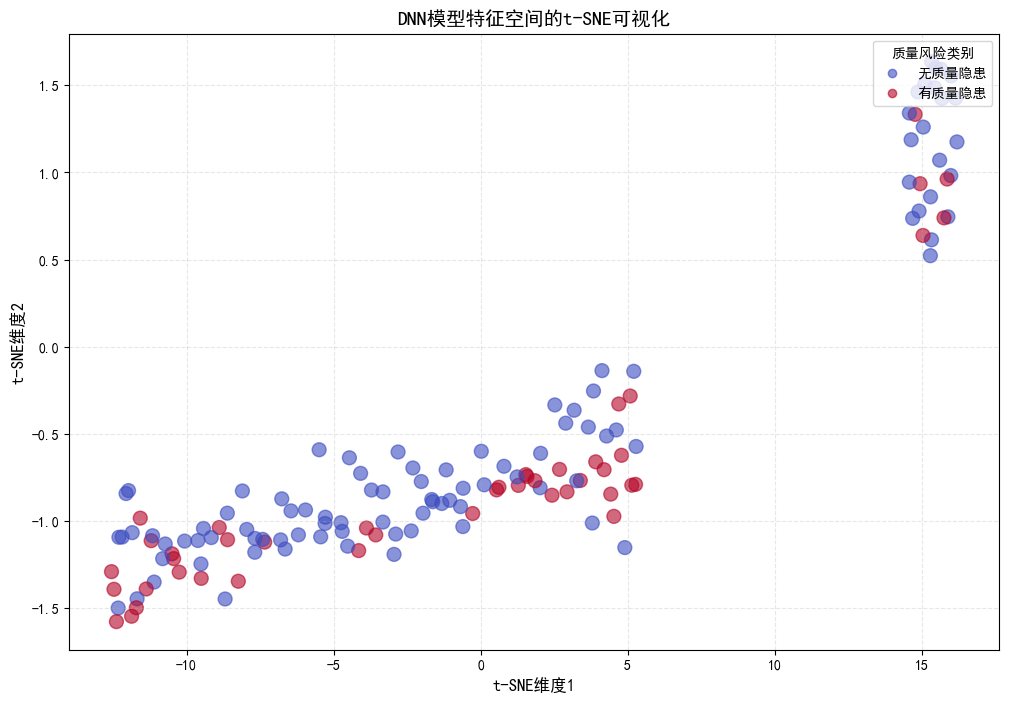

In [94]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
#支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  

# 1. 修改DNN模型以获取中间层输出
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
        )
        self.output = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, return_features=False):
        features = self.layers(x)
        output = self.output(features)
        if return_features:
            return output, features
        return output

# 2. 获取每个班次的特征表示
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DNN(X_tensor.shape[1]).to(device)

# 设置模型为评估模式
model.eval()
features_list = []
labels_list = []

with torch.no_grad():
    # 按班次进行聚合
    for shift_id in df_new['shift_id'].unique():
        # 获取当前班次的数据
        shift_data = df_new[df_new['shift_id'] == shift_id]
        # 提取特征（除去时间、标签和shift_id）
        shift_X = shift_data.drop(columns=['缺陷检测质量风险 Y', 'shift_id']).values
        
        # 标准化特征
        shift_X_normalized = scaler.transform(shift_X)
        
        # 转换为tensor并获取特征
        X_tensor = torch.FloatTensor(shift_X_normalized).to(device)
        _, features = model(X_tensor, return_features=True)
        
        # 计算该班次的平均特征
        shift_features = features.mean(dim=0).cpu().numpy()
        features_list.append(shift_features)
        
        # 获取该班次的标签（取第一个值即可，因为同一班次标签相同）
        labels_list.append(shift_data['缺陷检测质量风险 Y'].iloc[0])

# 转换为numpy数组
features_array = np.array(features_list)
labels_array = np.array(labels_list)

# 3. 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(features_array)

# 4. 创建可视化
plt.figure(figsize=(12, 8))

# 绘制散点图
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=labels_array,
                     cmap='coolwarm',
                     alpha=0.6,
                     s=100)  # 增大点的大小

# 添加图例
legend_elements = scatter.legend_elements()
plt.legend(legend_elements[0], ['无质量隐患', '有质量隐患'],
          title='质量风险类别',
          loc='upper right')

# 添加标题和标签
plt.title('DNN模型特征空间的t-SNE可视化', fontsize=14)
plt.xlabel('t-SNE维度1', fontsize=12)
plt.ylabel('t-SNE维度2', fontsize=12)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.3)

# 5. 输出分类统计信息
total_shifts = len(labels_array)
risk_shifts = np.sum(labels_array == 1)
no_risk_shifts = np.sum(labels_array == 0)

print("\nDNN模型分类效果分析:")
print(f"班次总数: {total_shifts}")
print(f"有质量隐患的班次数: {risk_shifts} ({risk_shifts/total_shifts*100:.2f}%)")
print(f"无质量隐患的班次数: {no_risk_shifts} ({no_risk_shifts/total_shifts*100:.2f}%)")

plt.show()

可以看到，用最朴素的想法得到的分类效果不说是相当差，至少也是很一般的。在各种指标上只能过看看过关。这就迫使我们寻找更有的思路和方法

## 进阶想法

### 数据重塑

In [95]:
max_len = df_new.groupby('shift_id').size().max()
X_grouped = []
Y_grouped = []

for _, group in df_new.groupby('shift_id'):
    # 处理X
    group_X = scaler.transform(group.drop(columns=['shift_id', '缺陷检测质量风险 Y']).values)
    group_Y = group['缺陷检测质量风险 Y'].values
    
    # 如果需要padding
    if len(group_X) < max_len:
        padding_rows = max_len - len(group_X)
        # X补0
        X_pad = np.pad(group_X, ((0, padding_rows), (0, 0)), mode='constant')
        # Y重复最后一个值
        Y_pad = np.pad(group_Y, (0, padding_rows), mode='edge')
    else:
        X_pad = group_X[:max_len]
        Y_pad = group_Y[:max_len]
    
    X_grouped.append(X_pad)
    Y_grouped.append(Y_pad)

# 合并
X_padded = np.vstack(X_grouped)
Y_padded = np.hstack(Y_grouped)
X_padded_tensor = torch.FloatTensor(X_padded)
Y_padded_tensor = torch.FloatTensor(Y_padded)
print("With padding:", X_padded_tensor.shape, Y_padded_tensor.shape)

With padding: torch.Size([3243, 9]) torch.Size([3243])


### 转化二维数据

In [96]:
# 重塑数据为141个样本，每个样本23行
n_samples = 141  # 总班次数
n_timesteps = 23  # 每个班次的时间步数
n_features = X_padded_tensor.shape[-1]  # 特征数量

# 重塑X
X_reshaped = X_padded_tensor.view(n_samples, n_timesteps, n_features)
print("重塑后的X形状:", X_reshaped.shape)

# 重塑Y 
Y_reshaped = Y_padded_tensor.view(n_samples, n_timesteps)
# 取每个班次的最后一个标签作为该班次的标签
Y_final = Y_reshaped[:,-1]
print("重塑后的Y形状:", Y_final.shape)


重塑后的X形状: torch.Size([141, 23, 9])
重塑后的Y形状: torch.Size([141])


### 构建一维卷积CNN模型


运行 CNN模型...
Early stopping at epoch 20
Early stopping at epoch 13
Early stopping at epoch 11
Early stopping at epoch 10
Early stopping at epoch 15

=== 5折交叉验证平均结果 ===
accuracy: 0.9360 (±0.0270)
f1: 0.8977 (±0.0386)
sensitivity: 0.8889 (±0.0703)
precision: 0.9156 (±0.0762)
auc: 0.9857 (±0.0132)


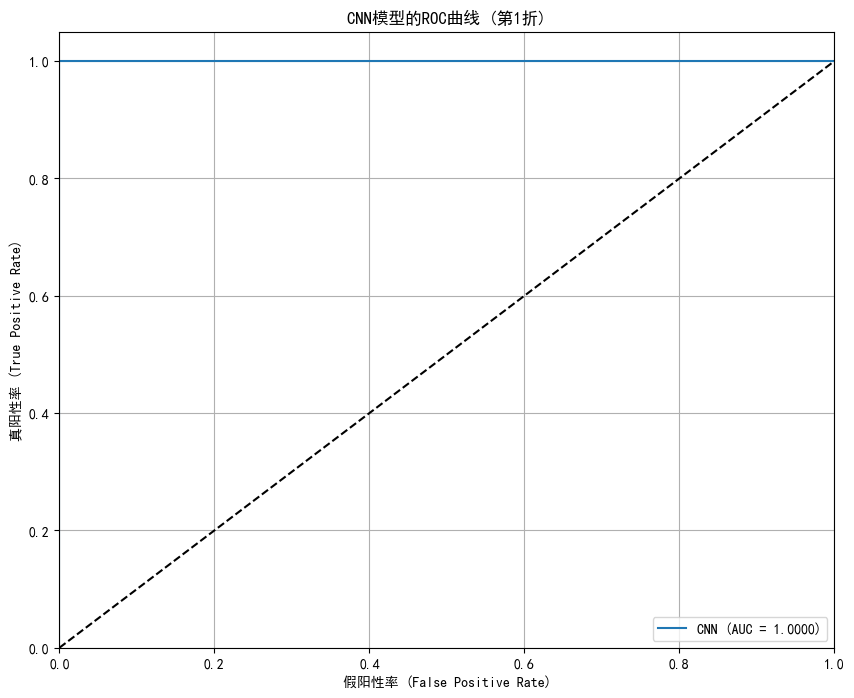

In [97]:
class CNN(nn.Module):
    def __init__(self, input_channels=9):
        super(CNN, self).__init__()
        
        # 第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        # 第二个卷积块
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        # 第三个卷积块
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        # 计算展平后的特征维度
        # 原始长度23，经过3次MaxPool后变为23/8≈2
        self.flatten_size = 128 * 2
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # 输入x的形状: [batch_size, time_steps, features]
        # 需要转换为: [batch_size, features, time_steps]
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # 展平
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

def train_evaluate_model(model, train_loader, val_loader, device, epochs=30):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                outputs = outputs.view(-1)
                val_loss += criterion(outputs, batch_y).item()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
    
    model.eval()
    val_preds = []
    val_probs = []
    val_true = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            probs = outputs.view(-1).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            val_preds.extend(preds)
            val_probs.extend(probs)
            val_true.extend(batch_y.numpy())
    
    return np.array(val_true), np.array(val_preds), np.array(val_probs)

def evaluate_metrics(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'sensitivity': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_prob)
    }

def run_experiment(X, y, model_class, device, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics_history = defaultdict(list)
    first_fold_data = None
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train), 
            torch.FloatTensor(y_train)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val), 
            torch.FloatTensor(y_val)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)
        
        model = model_class().to(device)
        y_true, y_pred, y_prob = train_evaluate_model(model, train_loader, val_loader, device)
        
        if fold == 0:
            first_fold_data = (y_true, y_prob)
        
        metrics = evaluate_metrics(y_true, y_pred, y_prob)
        for metric_name, value in metrics.items():
            metrics_history[metric_name].append(value)
    
    return metrics_history, first_fold_data

# 运行实验
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 准备数据
X = X_reshaped.numpy()
y = Y_final.numpy()

print("\n运行 CNN模型...")
metrics_history, first_fold_data = run_experiment(X, y, CNN, device)

# 输出结果
print("\n=== 5折交叉验证平均结果 ===")
metrics = ['accuracy', 'f1', 'sensitivity', 'precision', 'auc']
for metric in metrics:
    mean_value = np.mean(metrics_history[metric])
    std_value = np.std(metrics_history[metric])
    print(f"{metric}: {mean_value:.4f} (±{std_value:.4f})")

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
y_true, y_prob = first_fold_data
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
plt.plot(fpr, tpr, label=f'CNN (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 (False Positive Rate)')
plt.ylabel('真阳性率 (True Positive Rate)')
plt.title('CNN模型的ROC曲线 (第1折)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 构建二维卷积CNN模型


=== 5折交叉验证平均结果 ===
accuracy: 0.9360 (±0.0148)
f1: 0.8966 (±0.0229)
sensitivity: 0.8889 (±0.0703)
precision: 0.9156 (±0.0762)
auc: 0.9704 (±0.0226)


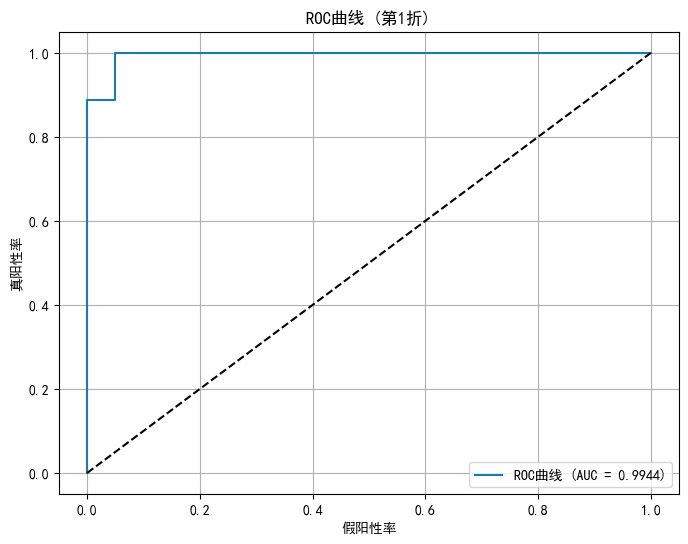

In [98]:
class Simple2DCNN(nn.Module):
    def __init__(self, input_channels=1):  # 默认输入通道为1
        super(Simple2DCNN, self).__init__()
        # 使用一个简单的2D卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        )
        
        # 计算展平后的特征维度：保持原始维度23x9
        self.flatten_size = 8 * 23 * 9
        
        # 一个简单的全连接层
        self.fc = nn.Linear(self.flatten_size, 1)
        
    def forward(self, x):
        # 输入x形状: [batch, time_steps, features]
        # 需要重塑为: [batch, channels, height, width]
        x = x.unsqueeze(1)  # 添加通道维度
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x).view(-1)

def train_evaluate_model(model, train_loader, val_loader, device, epochs=20):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        # 训练
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # 评估
    model.eval()
    val_preds = []
    val_probs = []
    val_true = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            probs = outputs.cpu().numpy()
            preds = (probs > 0.5).astype(int)
            val_preds.extend(preds)
            val_probs.extend(probs)
            val_true.extend(batch_y.numpy())
    
    return np.array(val_true), np.array(val_preds), np.array(val_probs)

def run_experiment(X, y, device, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics_history = defaultdict(list)
    first_fold_data = None
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train), 
            torch.FloatTensor(y_train)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val), 
            torch.FloatTensor(y_val)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16)
        
        model = Simple2DCNN().to(device)
        y_true, y_pred, y_prob = train_evaluate_model(model, train_loader, val_loader, device)
        
        if fold == 0:
            first_fold_data = (y_true, y_prob)
        
        metrics = evaluate_metrics(y_true, y_pred, y_prob)
        for metric_name, value in metrics.items():
            metrics_history[metric_name].append(value)
    
    return metrics_history, first_fold_data

# 运行实验
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metrics_history, first_fold_data = run_experiment(X, y, device)

# 输出结果
print("\n=== 5折交叉验证平均结果 ===")
metrics = ['accuracy', 'f1', 'sensitivity', 'precision', 'auc']
for metric in metrics:
    mean_value = np.mean(metrics_history[metric])
    std_value = np.std(metrics_history[metric])
    print(f"{metric}: {mean_value:.4f} (±{std_value:.4f})")

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
y_true, y_prob = first_fold_data
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
plt.plot(fpr, tpr, label=f'ROC曲线 (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('ROC曲线 (第1折)')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
wandb.finish()

In [100]:
# 1. 修改CNN模型以获取中间层特征
class CNN(nn.Module):
    def __init__(self, input_channels=9):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(0.2)
        )
        
        self.flatten_size = 128 * 2
        
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, return_features=False):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        features = x.view(x.size(0), -1)
        output = self.fc(features)
        
        if return_features:
            return output, features
        return output

class Simple2DCNN(nn.Module):
    def __init__(self, input_channels=1):
        super(Simple2DCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        )
        
        self.flatten_size = 8 * 23 * 9
        self.fc = nn.Linear(self.flatten_size, 1)
        
    def forward(self, x, return_features=False):
        x = x.unsqueeze(1)
        conv_out = self.conv(x)
        features = conv_out.view(conv_out.size(0), -1)
        output = torch.sigmoid(self.fc(features))
        
        if return_features:
            return output.view(-1), features
        return output.view(-1)

# 2. 预测和特征提取函数
def predict_and_get_features(model, data_loader, device):
    model.eval()
    predictions = []
    features_list = []
    
    with torch.no_grad():
        for batch in data_loader:
            X = batch[0].to(device)
            outputs, features = model(X, return_features=True)
            predictions.extend(outputs.cpu().numpy())
            features_list.extend(features.cpu().numpy())
    
    return np.array(predictions), np.array(features_list)

# 3. 准备测试数据
test_dataset = TensorDataset(torch.FloatTensor(X_test))
test_loader = DataLoader(test_dataset, batch_size=16)

# 4. 进行预测和特征提取
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_1d = CNN().to(device)
cnn_2d = Simple2DCNN().to(device)

# 获取预测结果和特征
cnn_1d_preds, cnn_1d_features = predict_and_get_features(cnn_1d, test_loader, device)
cnn_2d_preds, cnn_2d_features = predict_and_get_features(cnn_2d, test_loader, device)

# 5. 添加预测结果到df_test
df_test['预测_CNN1D'] = (cnn_1d_preds > 0.5).astype(int)
df_test['预测_CNN2D'] = (cnn_2d_preds > 0.5).astype(int)

# 6. t-SNE可视化
plt.figure(figsize=(15, 6))

# CNN 1D t-SNE
plt.subplot(1, 2, 1)
tsne = TSNE(n_components=2, random_state=42)
cnn_1d_tsne = tsne.fit_transform(cnn_1d_features)
plt.scatter(cnn_1d_tsne[:, 0], cnn_1d_tsne[:, 1], 
           c=df_test['预测_CNN1D'], cmap='coolwarm', alpha=0.6)
plt.title('1D CNN 特征空间的t-SNE可视化')
plt.xlabel('t-SNE维度1')
plt.ylabel('t-SNE维度2')

# CNN 2D t-SNE
plt.subplot(1, 2, 2)
cnn_2d_tsne = tsne.fit_transform(cnn_2d_features)
plt.scatter(cnn_2d_tsne[:, 0], cnn_2d_tsne[:, 1], 
           c=df_test['预测_CNN2D'], cmap='coolwarm', alpha=0.6)
plt.title('2D CNN 特征空间的t-SNE可视化')
plt.xlabel('t-SNE维度1')
plt.ylabel('t-SNE维度2')

plt.tight_layout()
plt.show()

# 7. 输出预测统计信息
print("\nCNN 1D预测统计:")
print(df_test['预测_CNN1D'].value_counts())
print("\nCNN 2D预测统计:")
print(df_test['预测_CNN2D'].value_counts())

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3